# Regression

In this tutorial, we will build a regression model for a two-color FRET dataset. The dataset has been manually labeled with a binary label per-frame indicating whether the frame should be included for next step analysis. To demonstrate the regression function of metasim, we will train a model to predict **how many** frames in a trace is labeled true.

# Preparation

If you are using Google Colab to run this notebook, or you are running locally for the first time, run the following section:

In [ ]:
import sys
import platform
import os
from IPython.display import display, HTML

# Define the maximum compatible Python version (3.11)
required_major = 3
required_minor_max = 11

current_version = f"{sys.version_info.major}.{sys.version_info.minor}"

if sys.version_info.major > required_major or \
   (sys.version_info.major == required_major and sys.version_info.minor > required_minor_max):

    is_colab = 'google.colab' in sys.modules
    is_conda = 'conda' in os.environ.get('CONDA_DEFAULT_ENV', '') or 'conda' in sys.executable
    is_venv = (not is_conda) and ('venv' in sys.executable or 'bin' in sys.executable or 'Scripts' in sys.executable)

    current_version = f"{sys.version_info.major}.{sys.version_info.minor}"
    print(f"❌ Current Python Version: {current_version} (Detected: {platform.python_version()})")
    print("----------------------------------------------------------------------------------")

    html_content = f"""
    <div style='border: 3px solid orange; padding: 15px; margin: 15px 0; border-radius: 8px;'>
        <h3 style='color: orange;'>&#x26A0; Compatibility Warning: Incompatible Python Version</h3>
        <p>This notebook requires <b>Python 3.11 or earlier</b> for compatibility with core deep learning libraries. Your runtime is currently using Python {current_version}.</p>
        
        <p>⚠️ **Temporary Solution:** We are actively working to migrate our codebase to the latest library versions. For now, please switch to the stable <b>2025.07 Colab Runtime</b> (if applicable) or a compatible local environment.</p>

        """
    
    if is_colab:
        html_content += """
        <h4>🔧 GOOGLE COLAB USER: How to Switch to the Fallback Runtime (Python 3.11)</h4>
        <ol>
            <li>Go to the main menu bar and click <b>Runtime</b>.</li>
            <li>Click <b>Command Palette...</b> (or use the shortcut: <code>Ctrl+Shift+P</code> or <code>Cmd+Shift+P</code>).</li>
            <li>In the search box, type and select: <b>"Use fallback runtime version"</b>.</li>
            <li>In the runtime version dropdown, select <b>2025.07 environment</b>. 
            <li>The runtime will restart, reconnecting you to the <b>2025.07 environment</b> with a compatible Python version (usually 3.11).</li>
        </ol>
        """
    
    # If not Colab, provide instructions for general virtual environments
    else:
        env_title = ""
        env_instructions = ""
        
        if is_conda:
            env_title = "Conda Environment Detected"
            env_instructions = """
            <p>Please recreate your environment using a compatible Python version (3.8 - 3.11).</p>
            <p><b>Example:</b> <code>conda create --name compatible_env python=3.11</code></p>
            <p><b>Activate:</b> <code>conda activate compatible_env</code></p>
            """
        elif is_venv:
            env_title = "Virtual Environment (venv) Detected"
            env_instructions = f"""
            <p>Please use a system Python version (3.8 - 3.11) to create a new environment.</p>
            <p><b>Example Steps:</b></p>
            <ol style='padding-left: 20px;'>
                <li>1. Create env (e.g., using Python 3.11): <code>python3.11 -m venv compatible_env</code></li>
                <li>2. Activate: <code>source compatible_env/bin/activate</code> (Linux/macOS) or <code>compatible_env\\Scripts\\activate</code> (Windows)</li>
            </ol>
            """
        else:
            env_title = "Local Environment Instructions"
            env_instructions = """
            <p>Please switch to a dedicated environment using a compatible Python version (3.8 - 3.11).</p>
            <p><b>Conda Example:</b> <code>conda create --name compatible_env python=3.11</code></p>
            <p><b>venv Example (Linux/macOS):</b> <code>python3.11 -m venv compatible_env</code> then <code>source compatible_env/bin/activate</code></p>
            """
            
        html_content += f"""
        <h4>💻 {env_title}:</h4>
        {env_instructions}
        """

    html_content += "</div>" # Close the main div
    display(HTML(html_content))

    # -----------------
    # 2. STOP EXECUTION
    # -----------------
    print("\n\nStopping execution to prevent errors. Please follow the instructions above and restart the runtime.")
    sys.exit(1) # Halt the notebook execution

# If the version is compatible (e.g., 3.11 or lower)
print(f"✅ Python Version {current_version} is compatible. Proceeding with execution.")

In [ ]:
! git clone https://github.com/simol-lab/META-SiM.git
! cp -r META-SiM/tutorials/saved_dataset .
! pip install metasim

# Start of Tutorial

In [1]:
import openfret
import metasim
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

# Load data

Here, we use dataset from the paper: 

Widom, J. R. et al. Ligand Modulates Cross-Coupling between Riboswitch Folding and Transcriptional
Pausing. Mol. Cell 72, 541-552.e6 (2018). 

We have converted the dataset into a train set and a test set, both in the OpenFRET format. For details on OpenFRET data format, please visit this [link](https://github.com/simol-lab/OpenFRET)

In [2]:
train_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_train.json.zip'),
    donor_channel_type="donor",  # Uses your channel type name in data
    acceptor_channel_type="acceptor", # Uses your channel type name in data
)
test_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_test.json.zip'),
    donor_channel_type="donor",  # Uses your channel type name in data
    acceptor_channel_type="acceptor",  # Uses your channel type name in data
)

To inspect the traces, the plot traces from each label class in the training dataset.

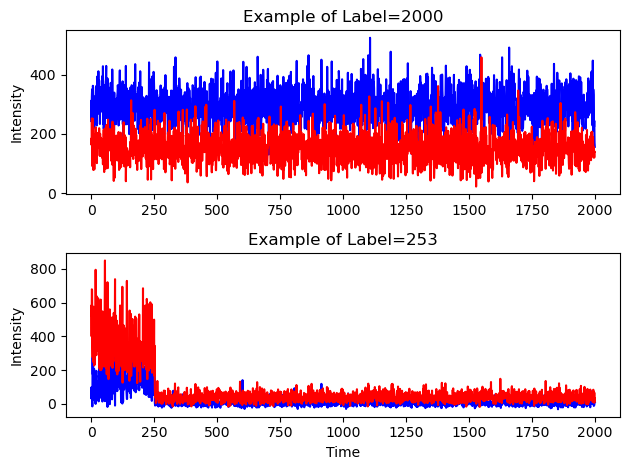

In [3]:
fig, axes = plt.subplots(2)
for trace in train_data.traces:
    if np.sum(trace.metadata['manual_label']) > 500:
        for channel in trace.channels:
            if channel.channel_type == 'donor':
                color = 'b'
            elif channel.channel_type == 'acceptor':
                color = 'r'
            axes[0].plot(channel.data, color=color)
            axes[0].set_ylabel('Intensity')
            axes[0].set_title(f'Example of Label={np.sum(trace.metadata["manual_label"])}')
        break
for trace in train_data.traces:
    if np.sum(trace.metadata['manual_label']) < 500:
        for channel in trace.channels:
            if channel.channel_type == 'donor':
                color = 'b'
            elif channel.channel_type == 'acceptor':
                color = 'r'
            axes[1].plot(channel.data, color=color)
            axes[1].set_ylabel('Intensity')
            axes[1].set_xlabel('Time')
            axes[1].set_title(f'Example of Label={np.sum(trace.metadata["manual_label"])}')
        break
plt.tight_layout()

# Regression Model

Here we use META-SiM's built-in function to train a regression model for this problem, based on the embeddings generated by META-SiM.

In [4]:
model = metasim.fret.Model()
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding = model(train_data)

  0%|          | 0/47 [00:00<?, ?it/s]

In [5]:
label = np.array([np.sum(trace.metadata['manual_label']) for trace in train_data.traces])

In [6]:
task_model = metasim.fret.tuning.train_regression(
    embedding,
    label,
)

Since META-SiM predicts the full probability distribution of the predicted label, at inference time, we can optimize for different eval metrics such as MAE and RMSE.

In [7]:
pred_mae = task_model.predict_regression(embedding, optimize_for='mae')
pred_rmse = task_model.predict_regression(embedding, optimize_for='rmse')

In [8]:
print('Training MAE for MAE prediction is', np.mean(np.abs(pred_mae - label)))
print('Training RMSE for RMSE prediction is', np.sqrt(np.sum(np.square(pred_rmse - label))))

Training MAE for MAE prediction is 89.32712765957447
Training RMSE for RMSE prediction is 789.5708318124305


# Evaluation on test data

We can use test data collected from different experimental trials to test the performance of the classification model. 

It's recommended to use data from different experiment trials for testing because in practice the model will be used on new experimental data.

In [9]:
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding_test = model(test_data)
label_test = np.array([trace.metadata['manual_label'] for trace in test_data.traces])

  0%|          | 0/1725 [00:00<?, ?it/s]

In [10]:
label_test = np.array([np.sum(trace.metadata['manual_label']) for trace in test_data.traces])

In [11]:
pred_mae_test = task_model.predict_regression(embedding_test, optimize_for='mae')
pred_rmse_test = task_model.predict_regression(embedding_test, optimize_for='rmse')

In [12]:
print('Test MAE for MAE prediction is', np.mean(np.abs(pred_mae_test - label_test)))
print('Test RMSE for RMSE prediction is', np.sqrt(np.sum(np.square(pred_rmse_test - label_test))))

Test MAE for MAE prediction is 231.7594927536232
Test RMSE for RMSE prediction is 12223.591783445552


Finally, we can show a scatter plot between the ground truth and the prediction for the test dataset.

Text(0.5, 1.0, 'Scatter plot between predicted and ground truth labels using META-SiM regression.')

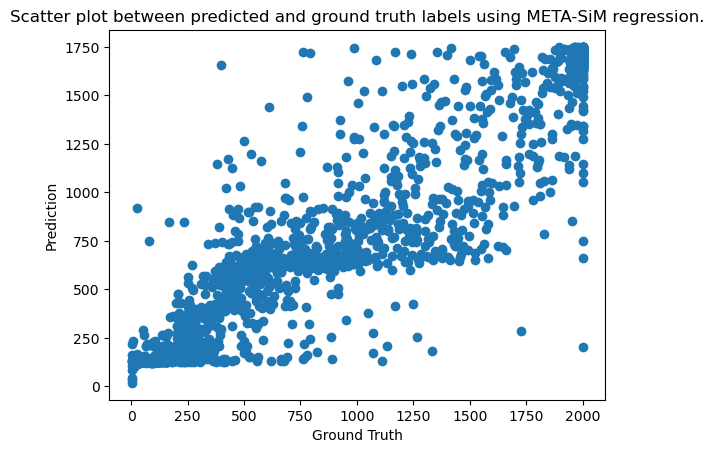

In [13]:
plt.scatter(label_test, pred_rmse_test)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Scatter plot between predicted and ground truth labels using META-SiM regression.')

# Save and load model

Now that we have a trained and validated the model, we will save it to re-use it in the future. Models can be easily saved and read with buit-in functions.

In [14]:
task_model.save_to_json('/tmp/saved_model.json')

In [15]:
loaded_model = metasim.fret.tools.tuning.ModelConfig.load_from_json(
    '/tmp/saved_model.json',
)